Install & Import libraries

In [1]:
pip install haversine

In [2]:
import pandas as pd
import pickle
import numpy as np
import os
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import math
import random
import scipy.spatial
#import geopy.distance
from haversine import haversine, Unit
#from sklearn.cluster import KMeans

sns.set_style('dark')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Get file paths of csv files

In [4]:
base_path = '/content/drive/MyDrive/Capstone_KMeans/new/data/Blockgroups/'
file_paths = os.listdir(base_path)
file_paths = [base_path + p for p in file_paths if p.endswith('.csv')]
file_paths

['/content/drive/MyDrive/Capstone_KMeans/new/data/Blockgroups/FULTON_CENTROIDS.csv',
 '/content/drive/MyDrive/Capstone_KMeans/new/data/Blockgroups/DEKALB_CENTOIDS.csv',
 '/content/drive/MyDrive/Capstone_KMeans/new/data/Blockgroups/BATON_CENTROIDS.csv',
 '/content/drive/MyDrive/Capstone_KMeans/new/data/Blockgroups/BALT_CENTROIDS.csv',
 '/content/drive/MyDrive/Capstone_KMeans/new/data/Blockgroups/TRAVIS_CENTROIDS.csv',
 '/content/drive/MyDrive/Capstone_KMeans/new/data/Blockgroups/MOBILE_CENTROIDS.csv']

Read in data for Baltimore

In [6]:
balt = pd.read_csv(file_paths[3])
balt.head(1)

,GISJOIN,STATE,COUNTY,TRACT,BLKGRP,TOTAL_POP,WHITE_POP,WHITE_PERCENTAGE,BIPOC_POP,INCOME,MAJ_BIPOC,MAJ_LOW_INCOME,LON,LAT
0,G24051000101001,Maryland,Baltimore city,10100,1,1185,1115,0.940928,70,145288.0,0,0,-76.574186,39.283297


Create 3 separate dataframes for weighting by:
- Population only
- Population & Demographics
- Population & Income

In [7]:
balt_pop = pd.DataFrame({'gisjoin':balt['GISJOIN'],'weight':balt['TOTAL_POP'],'lat':balt['LAT'],'lon':balt['LON']}, columns=['weight','lat','lon','gisjoin'])
balt_pop_income = pd.DataFrame({'low_income':balt['MAJ_LOW_INCOME'],'gisjoin':balt['GISJOIN'],'pop':balt['TOTAL_POP'],'income':balt['INCOME'],'lat':balt['LAT'],'lon':balt['LON']}, columns=['pop','income','lat','lon','gisjoin','low_income'])
balt_pop_demo = pd.DataFrame({'bipoc':balt['MAJ_BIPOC'],'gisjoin':balt['GISJOIN'],'pop':balt['TOTAL_POP'],'demo':balt['BIPOC_POP'],'lat':balt['LAT'],'lon':balt['LON']}, columns=['pop','demo','lat','lon','gisjoin','bipoc'])

In [8]:
balt_pop.head()

,weight,lat,lon,gisjoin
0,1185,39.283297,-76.574186,G24051000101001
1,761,39.281281,-76.574001,G24051000101002
2,1089,39.278634,-76.573583,G24051000101003
3,835,39.290586,-76.572760,G24051000102001
4,542,39.286420,-76.572252,G24051000102002


Rearrange dataframe for algorithm & create weights

In [9]:
# weighting parameters
a = 0.7
b = 1 - a

# create weight for population and income
weight = (balt_pop_income['income']**a) * (balt_pop_income['pop']**b)
balt_pop_income['weight'] = weight

# rearrange cols
#balt_pop_income = balt_pop_income[['weight','lat','lon','pop', 'income']]

# create weight for population and demographic
weight = (balt_pop_demo['demo']**a) * (balt_pop_demo['pop']**b)
balt_pop_demo['weight']=weight

# rearrange cols
#balt_pop_demo = balt_pop_demo[['weight','lat','lon','pop', 'demo']]

# get data into numpy arrays for algorithm
balt_pop_values = balt_pop[['weight','lat','lon']].values
balt_pop_demo_values = balt_pop_demo[['weight','lat','lon']].values
balt_pop_income_values = balt_pop_income[['weight','lat','lon']].values

In [10]:
len(balt_pop_values)

650

Display centers of neighborhoods

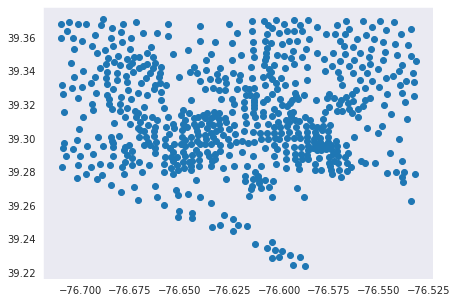

In [11]:
lat4 = balt_pop['lat'].values
lon4 = balt_pop['lon'].values
pop4 = balt_pop['weight'].values

plt.figure(figsize=(7,5))
plt.scatter(lon4,lat4);

Weighted K-Means  
Source: https://towardsdatascience.com/clustering-the-us-population-observation-weighted-k-means-f4d58b370002

In [12]:
# takes tuple (lat,lon) as coord
def distance(p1,p2):
  return haversine(p1[1:],p2[1:])


def cluster_centroids(data, clusters, k):
  results=[]

  for i in range(k):
    weights=np.squeeze(np.asarray(data[clusters == i][:,0:1]))
    a = np.average(data[clusters == i],weights=weights,axis=0)
    results.append(a)
  return results

def kmeans2(data, k=None, centroids=None, steps=200):
  # initialize k data oints randomly
  centroids = data[np.random.choice(np.arange(len(data)), k, False)]

  for _ in range(max(steps, 1)):
    # compute distance between each pair of the two collections of inputs
    sqdists = scipy.spatial.distance.cdist(centroids, data, lambda u, v: distance(u,v)**2)
    # Index of the closest centroid to each data point
    clusters = np.argmin(sqdists, axis=0)

    new_centroids = cluster_centroids(data, clusters, k)


    if np.array_equal(new_centroids, centroids):
      break
    centroids = new_centroids
  
  return clusters, centroids

Run WK-Means

In [13]:
k = 25
random.seed(42)

#run it
clusters,centroids=kmeans2(balt_pop_values,k)
clusters2,centroids2=kmeans2(balt_pop_demo_values,k)
clusters3,centroids3=kmeans2(balt_pop_income_values,k)

In [ ]:
centroids

In [ ]:
balt_pop.head(1)

,weight,lat,lon,gisjoin,centroid_id,centroid_coord,distance
0,1063,33.789523,-84.352065,G13012100001001,6,"[33.81183847095344, -84.36735426995673]",2.85533


Add distance to df

In [ ]:
def add_distances(centroids,clusters,df):
  centroid_coords = [centroids[i][1:] for i in clusters]
  df['centroid_id']=clusters
  df['centroid_coord']= centroid_coords
  df['distance'] = df.apply(lambda x: haversine([x.lat,x.lon],x.centroid_coord), axis = 1)
  return df

In [ ]:
df = add_distances(centroids,clusters,balt_pop)

In [ ]:
df.head()

,weight,lat,lon,gisjoin,centroid_id,centroid_coord,distance
0,1063,33.789523,-84.352065,G13012100001001,21,"[33.78302237353576, -84.36983222321355]",1.794034
1,1098,33.784457,-84.351341,G13012100001002,21,"[33.78302237353576, -84.36983222321355]",1.716384
2,1997,33.804334,-84.356345,G13012100001003,26,"[33.81884898403295, -84.37520976124023]",2.375441
3,1252,33.795260,-84.353680,G13012100001004,21,"[33.78302237353576, -84.36983222321355]",2.019841
4,1281,33.799961,-84.367718,G13012100002001,21,"[33.78302237353576, -84.36983222321355]",1.893589


In [ ]:
df.distance.mean() #35

1.9793316037385902

In [ ]:
df.distance.mean() #30

2.139703612534903

In [ ]:
df.distance.mean() #17

2.8477903052748577

In [ ]:
df.distance.mean() #25

2.3412893489519018

Compare weighting by different attributes

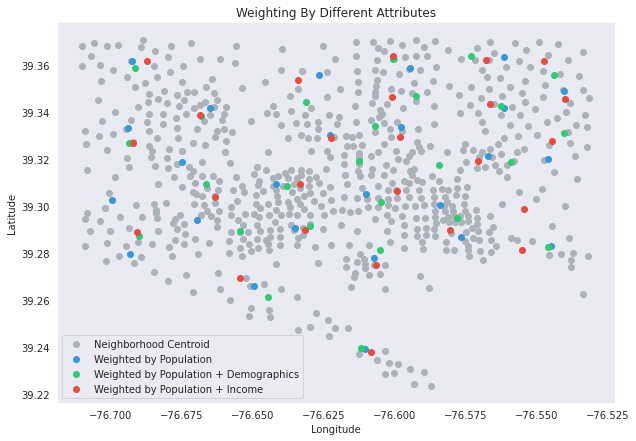

In [15]:
centroid_lon = [centroids[i][2] for i in range(len(centroids))]
centroid_lat = [centroids[i][1] for i in range(len(centroids))]
centroid_lon2 = [centroids2[i][2] for i in range(len(centroids2))]
centroid_lat2 = [centroids2[i][1] for i in range(len(centroids2))]
centroid_lon3 = [centroids3[i][2] for i in range(len(centroids3))]
centroid_lat3 = [centroids3[i][1] for i in range(len(centroids3))]

fig, ax = plt.subplots(figsize=(10,7));
white = ax.scatter(lon4,lat4, c='#ABB2B9');
black = ax.scatter(centroid_lon,centroid_lat,c='#3498DB'); 
green = ax.scatter(centroid_lon2,centroid_lat2,c='#2ECC71'); 
red = ax.scatter(centroid_lon3,centroid_lat3,c='#E74C3C'); 
ax.legend((white,black,green,red),('Neighborhood Centroid','Weighted by Population','Weighted by Population + Demographics','Weighted by Population + Income'));
plt.title('Weighting By Different Attributes');
plt.xlabel('Longitude');
plt.ylabel('Latitude');

In [20]:
import pickle
df_points = pd.DataFrame({'lon':centroid_lon,'lat':centroid_lat})
df_points.to_pickle('balt_points')

Function for plotting

In [ ]:
def plot_sites(clusters,centroids):

  centroid_lon = [centroids[i][2] for i in range(len(centroids))]
  centroid_lat = [centroids[i][1] for i in range(len(centroids))]

  fig, ax = plt.subplots(figsize=(10,7));
  ax.scatter(lon4,lat4, c=clusters, cmap='tab20c');
  ax.scatter(centroid_lon,centroid_lat,c='black'); 

Weighting by Population

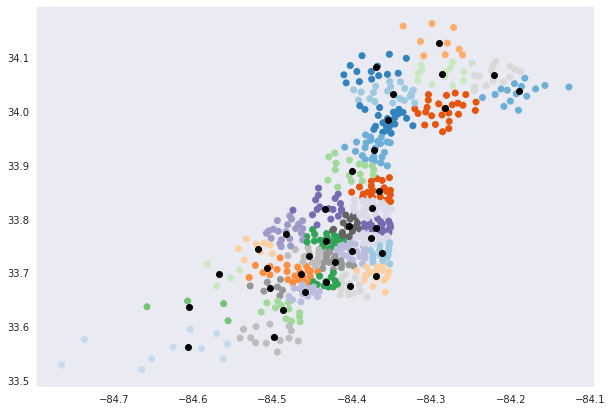

In [ ]:
plot_sites(clusters,centroids)

Weighting by Demographics

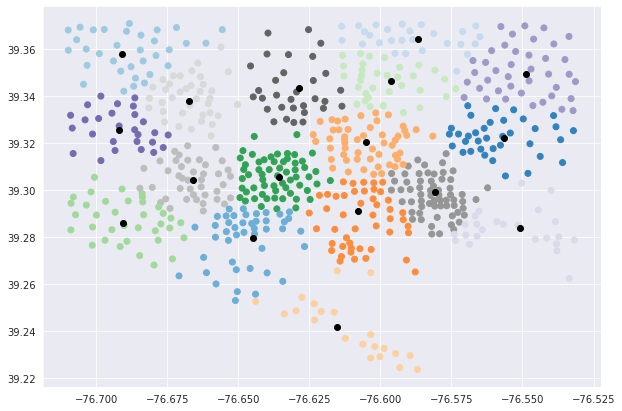

In [ ]:
plot_sites(clusters2,centroids2)

Weighting by Income

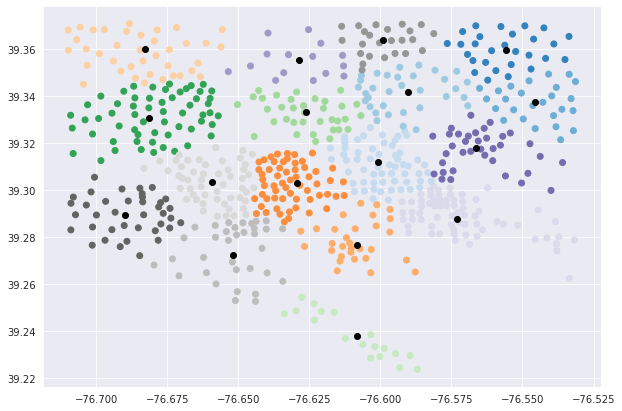

In [ ]:
plot_sites(clusters3,centroids3)

Save points to pickle file

In [ ]:
pop_centroids = pd.DataFrame({'lon':centroid_lon,'lat':centroid_lat})
demo_centroids = pd.DataFrame({'lon':centroid_lon2,'lat':centroid_lat2})
income_centroids = pd.DataFrame({'lon':centroid_lon3,'lat':centroid_lat3})

In [ ]:
pop_centroids.to_pickle('/content/pop_centroids.pkl')
demo_centroids.to_pickle('/content/demo_centroids.pkl')
income_centroids.to_pickle('/content/income_centroids.pkl')

In [ ]:
pop_centroids.to_csv('/content/new.csv')